# Test Model on Unseen Ticker

This notebook tests the trained model on a ticker that was NOT used during training.
This tests the model's generalization ability.

**Tickers used in training:** AAPL, MSFT, GOOGL, AMZN, META

**New ticker to test:** NVDA (NVIDIA) - tech stock, similar sector but unseen

In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

In [2]:
import torch
import numpy as np
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from src.data.pipeline import get_datasets, extract_dataset
from src.data.dataset import time_series_split
from src.models.transformer_model import StockTransformer
from src.simulation.engine import BacktestEngine
from src.simulation.metrics import compute_metrics
from src.utils.config import load_config, Config
from src.utils import config as _cfg

In [3]:
# Load config and modify for new ticker
config = load_config()

# ============================================================
# CHANGE THIS TICKER TO TEST DIFFERENT STOCKS
# ============================================================
NEW_TICKER = "CRM"  # Disney - entertainment/media stock


# Check what tickers are available (optional - just for info)
from src.data.loader import load_raw_dataset
print("Loading dataset to check available tickers...")
df_raw = load_raw_dataset(config=config)
if "symbol" in df_raw.columns:
    available_tickers = sorted(df_raw["symbol"].unique())
    print(f"\nAvailable tickers in dataset: {len(available_tickers)}")
    print(f"First 30: {available_tickers[:30]}")
    
    # Verify the ticker exists
    if NEW_TICKER not in available_tickers:
        print(f"\n⚠️  WARNING: {NEW_TICKER} not found in dataset!")
        print(f"Available tech stocks: {[t for t in ['NVDA', 'TSLA', 'AMD', 'INTC', 'ORCL', 'CRM'] if t in available_tickers]}")
        raise ValueError(f"Ticker {NEW_TICKER} not found. Choose from available tickers.")
    
    # Check if ticker was used in training
    training_tickers = set(config.data.tickers)
    if NEW_TICKER in training_tickers:
        print(f"\n⚠️  WARNING: {NEW_TICKER} was used in training!")
        print(f"This won't test generalization. Choose a different ticker.")
else:
    print("Warning: 'symbol' column not found.")

print(f"\n{'='*60}")
print(f"Testing on NEW ticker: {NEW_TICKER}")
print(f"Tickers used in training: {config.data.tickers}")
print(f"This ticker was NOT used during training - testing generalization!")
print(f"{'='*60}")

Loading dataset to check available tickers...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)

Available tickers in dataset: 321
First 30: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR']

Testing on NEW ticker: CRM
Tickers used in training: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
This ticker was NOT used during training - testing generalization!


In [4]:
# Load data for new ticker
# IMPORTANT: We need to use the SAME scaler as training, not train a new one
# So we'll load data WITHOUT normalization first, then apply the scaler from training

from copy import deepcopy
from src.data.loader import load_and_filter_dataset
from src.data.preprocessor import preprocess_data
from src.data.feature_engineering import create_all_features
from sklearn.preprocessing import StandardScaler
import pandas as pd

print(f"\nLoading data for {NEW_TICKER}...")

# Step 1: Load raw data for new ticker
test_config = deepcopy(config)
test_config.data.tickers = [NEW_TICKER]

df_raw = load_and_filter_dataset(
    config=test_config,
    tickers=[NEW_TICKER],
    start_date=test_config.data.start_date,
    end_date=test_config.data.end_date,
)

if len(df_raw) == 0:
    raise ValueError(f"No data found for {NEW_TICKER}. Available tickers: {available_tickers[:20]}")

print(f"Raw data loaded: {len(df_raw)} rows")

# Step 2: Preprocess (handle missing, outliers) but DON'T normalize yet
df_processed, _ = preprocess_data(
    df_raw,
    handle_missing=True,
    missing_method="forward_fill",
    handle_outliers_flag=True,
    outliers_method="clip",
    normalize=False,  # Don't normalize yet!
    date_column="date",
    symbol_column="symbol",
)

# Step 3: Create features
df_features = create_all_features(
    df_processed,
    price_column="close",
    high_column="high",
    low_column="low",
    volume_column="volume",
    date_column="date",
    symbol_column="symbol",
    windows=test_config.data.features.windows,
    lags=[1, 2, 3, 5, 10] if test_config.data.features.lag_features else [],
    add_technical=test_config.data.features.technical_indicators,
    add_lags=test_config.data.features.lag_features,
    add_temporal=test_config.data.features.temporal_features,
    add_volume=True,
    simplified=test_config.data.features.simplified,
)

df_features = df_features.dropna()

# Step 4: Get feature columns
feature_columns = [
    col for col in df_features.columns
    if col not in ["date", "symbol", "close"]
    and df_features[col].dtype in ['float64', 'int64', 'float32', 'int32']
]

print(f"Features created: {len(feature_columns)}")

# Step 5: Load ORIGINAL training data to fit scaler (same as training)
print("\nLoading original training data to get scaler parameters...")
df_train_original, _ = extract_dataset(config=config)  # Uses original tickers
train_df_original, _, _ = time_series_split(
    df_train_original,
    train_split=config.data.train_split,
    val_split=config.data.val_split,
    test_split=config.data.test_split,
)

# Step 6: Fit scaler on original training data (same as model training)
all_numeric_cols = feature_columns + ["close"]
scaler = StandardScaler()
scaler.fit(train_df_original[all_numeric_cols])
print(f"Scaler fitted on {len(train_df_original)} training samples")

# Step 7: Apply scaler to new ticker data
df_features[all_numeric_cols] = scaler.transform(df_features[all_numeric_cols])
print(f"Scaler applied to {NEW_TICKER} data")

# Step 8: Split into train/val/test (we'll use test split for backtest)
train_df, val_df, test_df = time_series_split(
    df_features,
    train_split=test_config.data.train_split,
    val_split=test_config.data.val_split,
    test_split=test_config.data.test_split,
)

print(f"\nData loaded and normalized:")
print(f"  Train: {len(train_df)} rows")
print(f"  Val: {len(val_df)} rows")
print(f"  Test: {len(test_df)} rows")
print(f"  Features: {len(feature_columns)}")

if 'symbol' in test_df.columns:
    print(f"\nTickers in test set: {sorted(test_df['symbol'].unique())}")


Loading data for CRM...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2578, 25)
Raw data loaded: 2578 rows
Features created: 34

Loading original training data to get scaler parameters...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
Scaler fitted on 6936 training samples
Scaler applied to CRM data

Data loaded and normalized:
  Train: 1778 rows
  Val: 381 rows
  Test: 381 rows
  Features: 34

Tickers in test set: ['CRM']


In [5]:
# Load simulation config
config_path = _cfg.PROJECT_ROOT / "configs" / "default_config.yaml"
with config_path.open("r", encoding="utf-8") as f:
    raw_cfg = yaml.safe_load(f)
sim = raw_cfg.get("simulation", {})

initial_capital = float(sim.get("initial_capital", 100_000))
position_size_pct = float(sim.get("position_size_pct", 0.3))
entry_threshold_pct = float(sim.get("entry_threshold_pct", 0.5))
exit_threshold_pct = float(sim.get("exit_threshold_pct", -5.0))
commission_pct = float(sim.get("commission_pct", 0.1))
risk_free_rate_annual = float(sim.get("risk_free_rate_annual", 0.03))

print(f"Simulation config: capital={initial_capital}, position_size={position_size_pct}, ")
print(f"entry_threshold={entry_threshold_pct}%, exit_threshold={exit_threshold_pct}%, commission={commission_pct}%")

Simulation config: capital=100000.0, position_size=0.3, 
entry_threshold=0.5%, exit_threshold=-5.0%, commission=0.1%


In [6]:
# Load the trained model (trained on AAPL, MSFT, GOOGL, AMZN, META)
checkpoint_name = config.paths.checkpoint_file
checkpoint_path = _cfg.PROJECT_ROOT / config.paths.models_dir / checkpoint_name

print(f"Loading model from: {checkpoint_path}")
if checkpoint_path.exists():
    import time
    mod_time = time.ctime(checkpoint_path.stat().st_mtime)
    print(f"Loaded: {checkpoint_name} (modified {mod_time})")
else:
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint["model_state_dict"]

print(f"Checkpoint: epoch {checkpoint.get('epoch', '?')}, val loss {checkpoint.get('score', '?'):.6f}")

# Handle input_dim mismatch (new ticker might have different feature count)
input_dim_checkpoint = state_dict["input_projection.weight"].shape[1]
input_dim_current = len(feature_columns)
d_model = state_dict["input_projection.weight"].shape[0]
n_layers = len([k for k in state_dict if "encoder.layers" in k and "self_attention.w_q.weight" in k])
n_heads = config.model.n_heads
d_ff = state_dict["encoder.layers.0.feed_forward.linear1.weight"].shape[0]

if input_dim_checkpoint != input_dim_current:
    print(f"\nWARNING: Input dimension mismatch!")
    print(f"  Checkpoint: {input_dim_checkpoint} features")
    print(f"  Current data: {input_dim_current} features")
    print(f"  This might happen if feature engineering differs.")
    print(f"  Using compatible parameters only...")
    
    model = StockTransformer(
        input_dim=input_dim_current,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in state_dict.items()
                      if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict, strict=False)
    print(f"Loaded {len(compatible_dict)}/{len(state_dict)} params (input_dim mismatch: using current features)")
else:
    model = StockTransformer(
        input_dim=input_dim_checkpoint,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model.load_state_dict(state_dict)
    print("Model loaded successfully.")

model.eval()

Loading model from: C:\Users\vyoto\OneDrive\Desktop\CODE STUFF\Stock price prediction\models\checkpoints\best_model.pt
Loaded: best_model.pt (modified Thu Feb  5 14:04:36 2026)
Checkpoint: epoch 29, val loss 0.014834
Model loaded successfully.


StockTransformer(
  (input_projection): Linear(in_features=34, out_features=128, bias=True)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attention): MultiHeadAttention(
          (w_q): Linear(in_features=128, out_features=128, bias=True)
          (w_k): Linear(in_features=128, out_features=128, bias=True)
          (w_v): Linear(in_features=128, out_features=128, bias=True)
          (w_o): Linear(in_features=128, out_features=128, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.

In [7]:
# Create dataset for test period
from src.data.dataset import StockDataset, create_sequences

# Extract features and target from test_df
test_data = test_df[feature_columns].values
test_targets = test_df["close"].values.reshape(-1, 1)

# Create sequences manually (same logic as prepare_dataset)
test_X, test_y = create_sequences(
    np.column_stack([test_data, test_targets]),
    config.data.context_length,
    config.data.prediction_horizon,
)

# Extract features (remove target column)
test_X = test_X[:, :, :-1]

# Extract target properly based on prediction_horizon
if config.data.prediction_horizon > 1:
    test_y = test_y[:, :, -1]
else:
    test_y = test_y[:, -1, -1]
    if test_y.ndim == 0:
        test_y = test_y.reshape(-1, 1)

# Create StockDataset
test_dataset = StockDataset(
    data=test_X,
    targets=test_y,
    context_length=config.data.context_length,
    prediction_horizon=config.data.prediction_horizon,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)

print(f"Test dataset: {len(test_dataset)} samples")
print(f"Context length: {config.data.context_length} days")
print(f"Prediction horizon: {config.data.prediction_horizon} day(s)")
print(f"Features shape: {test_X.shape}, Targets shape: {test_y.shape}")

Test dataset: 321 samples
Context length: 60 days
Prediction horizon: 1 day(s)
Features shape: (321, 60, 34), Targets shape: (321,)


In [8]:
# Generate predictions for test period
print("Generating predictions...")
predictions = []
prices_list = []

with torch.no_grad():
    for batch in test_loader:
        features, targets = batch
        preds = model(features)
        predictions.append(preds.cpu().numpy())
        prices_list.append(targets.cpu().numpy())

pred_next = np.concatenate(predictions).ravel()
prices = np.concatenate(prices_list).ravel()

# For backtest, we need prices and predictions aligned
# Prices[i] is the price on day i, pred_next[i] is prediction for day i+1
# So we need to align: use prices[context_length:] and pred_next[:-1] or similar
# Actually, StockDataset returns targets that are prices at t+prediction_horizon
# So prices[i] is price at day i+prediction_horizon relative to features[i]

# For backtest, we need:
# - prices: actual prices for each day we can trade
# - predictions: predictions for next day price

# StockDataset uses context_length days of features to predict price at t+prediction_horizon
# So if we have N samples, we have predictions for days [context_length, context_length+N-1]
# We need to extract actual prices for those days

# Get actual prices from test_df
test_prices = test_df["close"].values
context_length = config.data.context_length

# Prices we can actually use for backtest (starting from context_length)
prices_for_backtest = test_prices[context_length:]

# Align predictions with prices
# pred_next[i] predicts price at day context_length + i + prediction_horizon
# But we want prediction for day context_length + i + 1
# So we use pred_next[i] as prediction for prices_for_backtest[i+prediction_horizon-1]

# Actually, simpler: if prediction_horizon=1, then pred_next[i] predicts prices_for_backtest[i]
# But we need to shift: pred_next[i] predicts the NEXT price after prices_for_backtest[i]

# Let's align properly:
# - prices_for_backtest[0] is price on day context_length
# - pred_next[0] predicts price on day context_length + prediction_horizon
# So for backtest on day i, we use:
#   current_price = prices_for_backtest[i]
#   predicted_price = pred_next[i] (predicts price for day i+1 if prediction_horizon=1)

# For simplicity, let's use:
if len(pred_next) == len(prices_for_backtest):
    # Perfect alignment
    prices = prices_for_backtest
    pred_next = pred_next
elif len(pred_next) == len(prices_for_backtest) - config.data.prediction_horizon:
    # Need to shift
    prices = prices_for_backtest[config.data.prediction_horizon:]
    pred_next = pred_next
else:
    # Use minimum length
    min_len = min(len(pred_next), len(prices_for_backtest))
    prices = prices_for_backtest[:min_len]
    pred_next = pred_next[:min_len]

print(f"\nBacktest data:")
print(f"  Prices: {len(prices)} days")
print(f"  Predictions: {len(pred_next)} days")
print(f"  Price range: [{prices.min():.4f}, {prices.max():.4f}]")
print(f"  Prediction range: [{pred_next.min():.4f}, {pred_next.max():.4f}]")

Generating predictions...

Backtest data:
  Prices: 321 days
  Predictions: 321 days
  Price range: [124.3000, 211.0142]
  Prediction range: [-0.8137, -0.5673]


In [9]:
# Run backtest simulation
print(f"\n{'='*60}")
print(f"BACKTEST ON NEW TICKER: {NEW_TICKER}")
print(f"{'='*60}")

engine = BacktestEngine(
    initial_capital=initial_capital,
    position_size_pct=position_size_pct,
    entry_threshold_pct=entry_threshold_pct,
    exit_threshold_pct=exit_threshold_pct,
    commission_pct=commission_pct,
)

result = engine.run(prices=prices, predictions=pred_next)

metrics = compute_metrics(
    result,
    initial_capital=initial_capital,
    risk_free_rate_annual=risk_free_rate_annual,
    prices=prices,
)

print("=" * 60)
print("BACKTEST METRICS")
print("=" * 60)
print(f"Total return:        {metrics.total_return_pct:.2f}%")
print(f"Sharpe (annual):     {metrics.sharpe_ratio_annual:.3f}")
print(f"Max drawdown:        {metrics.max_drawdown_pct:.2f}%")
print(f"Number of trades:    {metrics.num_trades}")
if metrics.buy_and_hold_return_pct is not None:
    print(f"Buy & hold return:   {metrics.buy_and_hold_return_pct:.2f}%")
if metrics.excess_return_vs_bh_pct is not None:
    print(f"Excess vs B&H:       {metrics.excess_return_vs_bh_pct:+.2f}%")
print("=" * 60)

# Show first few trades
print(f"\nFirst 10 trades:")
for i, trade in enumerate(result.trades[:10]):
    print(f"  Trade {i+1}: Day {trade.date_idx} - {trade.side.upper()} {trade.quantity:.2f} shares @ {trade.price:.4f}")

if len(result.trades) > 10:
    print(f"  ... and {len(result.trades) - 10} more trades")


BACKTEST ON NEW TICKER: CRM
BACKTEST METRICS
Total return:        -9.28%
Sharpe (annual):     -0.861
Max drawdown:        15.10%
Number of trades:    1
Buy & hold return:   30.85%
Excess vs B&H:       -40.13%

First 10 trades:
  Trade 1: Day 0 - SELL 186.02 shares @ 161.2700


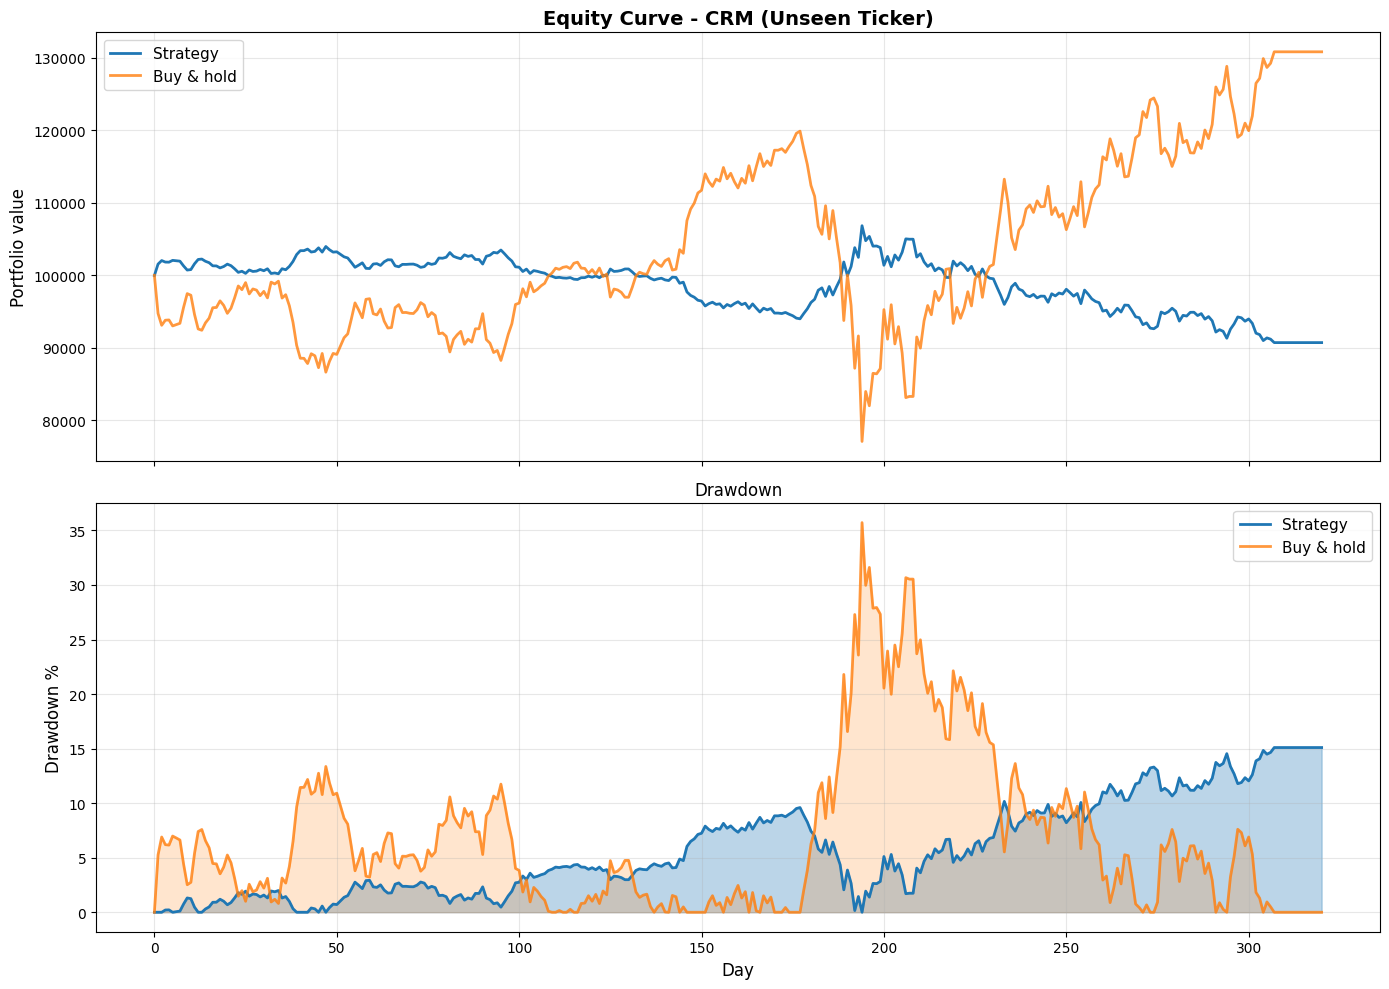


SUMMARY: Model tested on CRM (unseen during training)
Strategy return: -9.28%
Buy & hold return: 30.85%
Excess return: -40.13%
Number of trades: 1

This shows how well the model generalizes to new stocks!


: 

In [ ]:
# Plot results
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax1 = axes[0]
ax1.plot(result.equity_curve, label="Strategy", linewidth=2)
# Buy & hold: for normalized prices, use relative change
pct_change_cumulative = (prices - prices[0]) / np.abs(prices[0])
bh_value = initial_capital * (1 + pct_change_cumulative)
ax1.plot(bh_value, label="Buy & hold", alpha=0.8, linewidth=2)
ax1.set_ylabel("Portfolio value", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_title(f"Equity Curve - {NEW_TICKER} (Unseen Ticker)", fontsize=14, fontweight="bold")

ax2 = axes[1]
x = np.arange(len(result.equity_curve))
peak = np.maximum.accumulate(result.equity_curve)
safe_peak = np.where(peak <= 0, np.nan, peak)
dd = 100 * (peak - result.equity_curve) / safe_peak
dd = np.nan_to_num(dd, nan=0.0)
ax2.plot(x, dd, label="Strategy", color="C0", linewidth=2)
ax2.fill_between(x, dd, 0, alpha=0.3, color="C0")
bh_value_dd = initial_capital * (1 + (prices - prices[0]) / np.abs(prices[0]))
peak_bh = np.maximum.accumulate(bh_value_dd)
safe_peak_bh = np.where(peak_bh <= 0, np.nan, peak_bh)
dd_bh = 100 * (peak_bh - bh_value_dd) / safe_peak_bh
dd_bh = np.nan_to_num(dd_bh, nan=0.0)
ax2.plot(x, dd_bh, label="Buy & hold", color="C1", alpha=0.8, linewidth=2)
ax2.fill_between(x, dd_bh, 0, alpha=0.2, color="C1")
ax2.set_ylabel("Drawdown %", fontsize=12)
ax2.set_xlabel("Day", fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_title("Drawdown", fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"SUMMARY: Model tested on {NEW_TICKER} (unseen during training)")
print(f"{'='*60}")
print(f"Strategy return: {metrics.total_return_pct:.2f}%")
print(f"Buy & hold return: {metrics.buy_and_hold_return_pct:.2f}%" if metrics.buy_and_hold_return_pct else "N/A")
print(f"Excess return: {metrics.excess_return_vs_bh_pct:+.2f}%" if metrics.excess_return_vs_bh_pct else "N/A")
print(f"Number of trades: {metrics.num_trades}")
print(f"\nThis shows how well the model generalizes to new stocks!")